### Detecting temporal coordination of high-power bursts

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import itertools
import os

import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from frites.conn.conn_spec import conn_spec
from frites.conn.conn_tf import _tf_decomp
from frites.utils import parallel_func
from scipy.signal import find_peaks
from tqdm import tqdm

from config import sessions
from GDa.session import session, session_info
from GDa.signal.surrogates import trial_swap_surrogates
from GDa.temporal_network import temporal_network
from GDa.util import _extract_roi, average_stages, create_stages_time_grid

#### Load power

In [3]:
tt = 1
br = 1
at = "cue"
session = "141024"

_ROOT = os.path.expanduser("~/funcog/gda")
_FILE_NAME = f"power_tt_{tt}_br_{br}_at_{at}.nc"

power = xr.load_dataarray(
    os.path.join(_ROOT, f"Results/lucy/{session}/session01", _FILE_NAME)
)

100%|████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


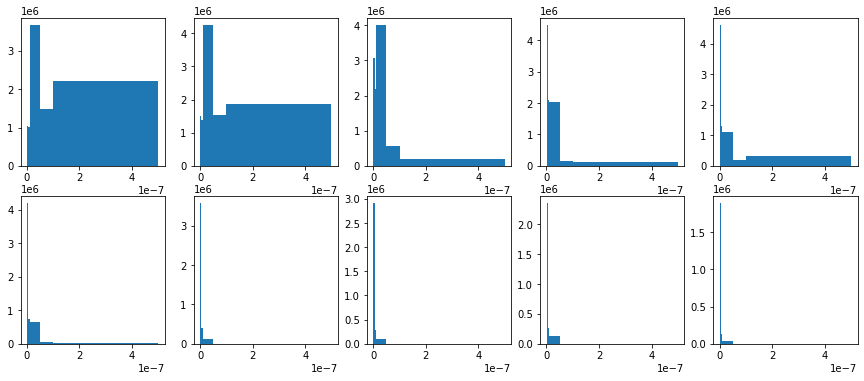

In [4]:
bins = np.array([1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 5e-7])

plt.figure(figsize=(15, 6))
for f in tqdm(range(power.sizes["freqs"])):
    plt.subplot(2, 5, f + 1)
    plt.hist(power.isel(freqs=f).data.flatten(), bins=bins)

#### Filtring power activations

In [52]:
thresholds = np.geomspace(1e-9, 1e-6, 60)

In [53]:
unique_rois = np.unique(power.roi.data)

In [54]:
ntrials = power.sizes["trials"]
nfreqs = power.sizes["freqs"]
nrois = len(unique_rois)
nthr = len(thresholds)

In [55]:
n_act = np.zeros((nrois, nfreqs, nthr))

for f in tqdm(range(nfreqs)):
    for t in range(nthr):
        power_thr = power.isel(freqs=f) > thresholds[t]
        n_act[:, f, t] = power_thr.mean(("trials", "times")).groupby("roi").mean("roi")

n_act = xr.DataArray(
    n_act, dims=("roi", "freqs", "thr"), coords=(unique_rois, power.freqs, thresholds)
)

100%|████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


100%|████████████████████████████| 10/10 [00:00<00:00, 26.76it/s]


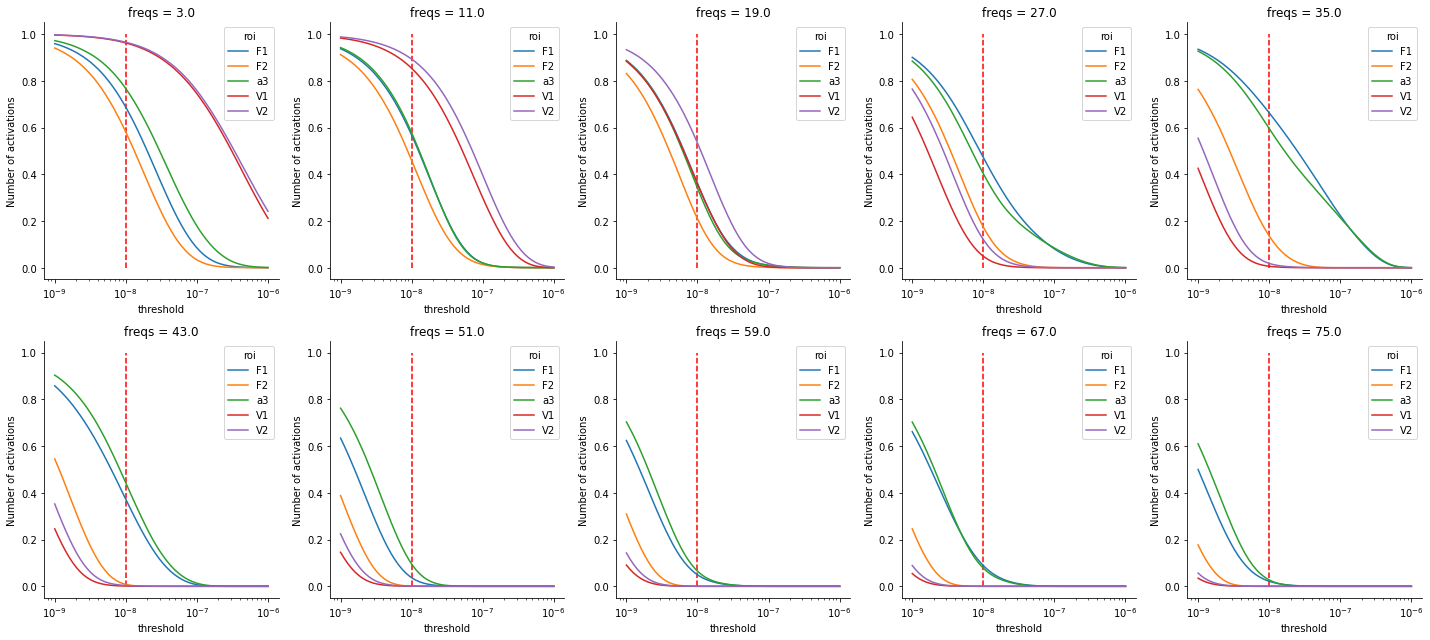

In [56]:
plt.figure(figsize=(20, 9))
for f in tqdm(range(nfreqs)):
    ax = plt.subplot(2, 5, f + 1)
    n_act.isel(freqs=f).sel(roi=["F1", "F2", "a3", "V1", "V2"]).plot(
        x="thr", hue="roi", xscale="log"
    )
    plt.ylabel("Number of activations")
    plt.xlabel("threshold")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.vlines(1e-8, 0, 1, color="r", ls="--")
plt.tight_layout()

#### Load coherence

In [10]:
coh_file = f"coh_at_cue.nc"
coh_sig_file = f"thr_coh_at_cue_surr.nc"

In [104]:
net = temporal_network(
    coh_file=coh_file,
    coh_sig_file=coh_sig_file,
    wt=None,
    date=session,
    trial_type=[1],
    behavioral_response=[1],
)

In [148]:
power_thr = power.sel(freqs=35) >= 2e-8
c = net.super_tensor.sel(freqs=35) > 0.1

Text(0.5, 1.0, 'Coactivation on areas V1 - F1 (thr = 2e-8, f=35 Hz)')

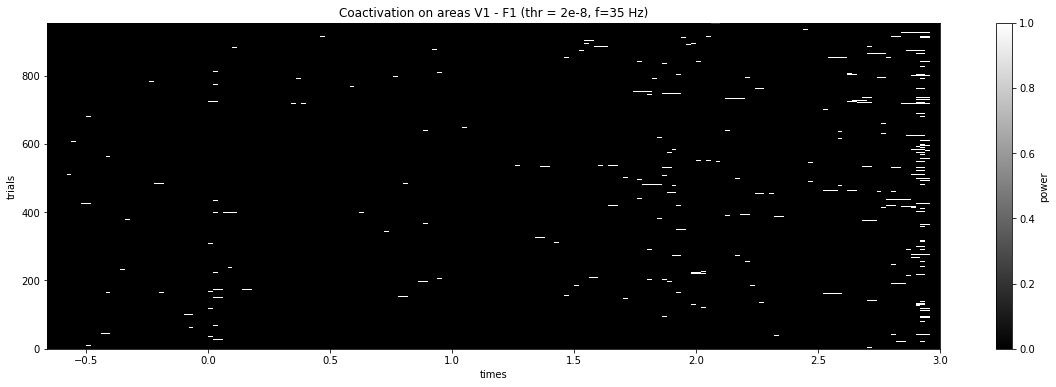

In [149]:
plt.figure(figsize=(20, 6))

(
    (power_thr.sel(roi="V1").mean("roi") > 0)
    * (power_thr.sel(roi="F1").mean("roi") > 0)
).plot.imshow(x="times", y="trials", origin="lower", cmap="binary_r")

plt.title("Coactivation on areas V1 - F1 (thr = 2e-8, f=35 Hz)")

In [150]:
a = (
    (c.sel(roi="F1-V1").mean("roi") > 0).astype(int)
    * (power_thr.sel(roi="V1").mean("roi") > 0).astype(int)
    * (power_thr.sel(roi="F1").mean("roi") > 0).astype(int)
)

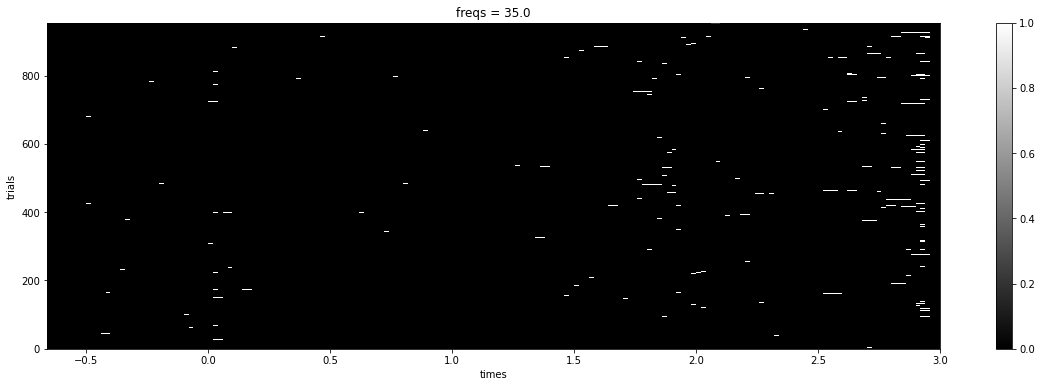

In [151]:
plt.figure(figsize=(20, 6))

a.plot.imshow(x="times", y="trials", origin="lower", cmap="binary_r")

In [154]:
m = np.zeros((ntrials, nthr))
i = 0
c = net.super_tensor.sel(freqs=35) > 0.1
for thr in tqdm(thresholds):
    power_thr = power.sel(freqs=35) >= thr
    a = (
        (c.sel(roi="F1-V1").mean("roi") > 0).astype(int)
        * (power_thr.sel(roi="V1").mean("roi") > 0).astype(int)
        * (power_thr.sel(roi="F1").mean("roi") > 0).astype(int)
    )
    m[:, i] = a.mean("times")
    i = i + 1

100%|████████████████████████████| 60/60 [00:03<00:00, 18.75it/s]


Text(0, 0.5, 'Coincidence power-power-coh')

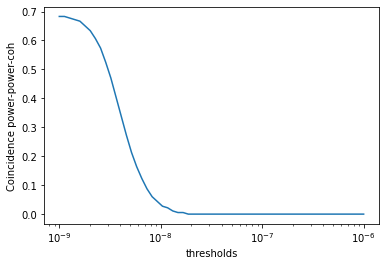

In [162]:
plt.semilogx(thresholds, np.median(m, 0))
plt.xlabel("thresholds")
plt.ylabel("Coincidence power-power-coh")